In [12]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [13]:
class BitcoinPredictor:
    def __init__(self, sequence_length=60, prediction_horizon=30):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.model = None
        self.scaler = None
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio', 
                           'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns', 
                               'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20', 
                         'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal', 
                         'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 
                          'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7', 
                         'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
        
    def engineer_30day_target(self, df):
        """Engineer 30-day forward returns target"""
        df_target = df.copy()
        # Calculate 30-day forward return
        df_target['target_return_30d'] = (df_target['close'].shift(-self.prediction_horizon) - 
                                         df_target['close']) / df_target['close']
        
        # Optional: Add 30-day forward direction for classification
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        
        # Remove rows that don't have 30-day forward data
        df_target = df_target.dropna()
        return df_target
    
    def prepare_features(self, df):
        """Prepare and scale features"""
        # Get all feature columns (exclude target and metadata)
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        # Filter to only existing columns
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Add any additional features not in groups
        additional_features = [col for col in df.columns if col not in available_features 
                             and col not in ['target_return_30d', 'target_direction_30d', 
                                           'next_close', 'target_return', 'target_direction']]
        
        all_features = available_features + additional_features
        
        print(f"Using {len(all_features)} features: {all_features}")
        
        # Scale features
        self.scaler = RobustScaler()  # More robust to outliers than StandardScaler
        scaled_features = self.scaler.fit_transform(df[all_features])
        
        return scaled_features, all_features
    
    def create_sequences(self, features, targets):
        """Create sequences for LSTM training"""
        X, y = [], []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            X.append(features[i:(i + self.sequence_length)])
            y.append(targets[i + self.sequence_length])
        
        return np.array(X), np.array(y)
    
    def build_model(self, input_shape):
        """Build hybrid CNN-LSTM model"""
        # Input layer
        inputs = layers.Input(shape=input_shape)
        
        # CNN Branch - Extract local patterns
        cnn_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                  padding='same')(inputs)
        cnn_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                  padding='same')(cnn_branch)
        cnn_branch = layers.MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = layers.Dropout(0.2)(cnn_branch)
        
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                                  padding='same')(cnn_branch)
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                                  padding='same')(cnn_branch)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # LSTM Branch - Capture temporal dependencies
        lstm_branch = layers.LSTM(100, return_sequences=True, dropout=0.2, 
                                 recurrent_dropout=0.2)(inputs)
        lstm_branch = layers.LSTM(50, return_sequences=True, dropout=0.2, 
                                 recurrent_dropout=0.2)(lstm_branch)
        lstm_branch = layers.LSTM(25, dropout=0.2, recurrent_dropout=0.2)(lstm_branch)
        
        # Attention mechanism for LSTM
        attention = layers.Dense(25, activation='tanh')(lstm_branch)
        attention = layers.Dense(1, activation='sigmoid')(attention)
        lstm_weighted = layers.multiply([lstm_branch, attention])
        
        # Combine CNN and LSTM features
        combined = layers.concatenate([cnn_branch, lstm_weighted])
        
        # Dense layers for final prediction
        dense = layers.Dense(128, activation='relu')(combined)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        dense = layers.Dense(32, activation='relu')(dense)
        
        # Output layer - regression for 30-day returns
        output = layers.Dense(1, activation='linear', name='return_prediction')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        
        # Compile with custom loss function for financial data
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
        return model
    
    def train(self, df, validation_split=0.2, epochs=100, batch_size=32):
        """Train the model"""
        # Engineer 30-day target
        df_processed = self.engineer_30day_target(df)
        print(f"Data shape after 30-day target engineering: {df_processed.shape}")
        
        # Prepare features
        features, feature_names = self.prepare_features(df_processed)
        targets = df_processed['target_return_30d'].values
        
        # Create sequences
        X, y = self.create_sequences(features, targets)
        print(f"Sequence shape: X={X.shape}, y={y.shape}")
        
        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, shuffle=False  # No shuffle for time series
        )
        
        # Build model
        self.model = self.build_model((X.shape[1], X.shape[2]))
        print(self.model.summary())
        
        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6
        )
        
        # Train model
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history, X_val, y_val
    
    def evaluate_model(self, X_val, y_val):
        """Evaluate model performance"""
        predictions = self.model.predict(X_val)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, predictions)
        mse = mean_squared_error(y_val, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, predictions)
        
        # Direction accuracy
        direction_accuracy = np.mean(np.sign(y_val) == np.sign(predictions.flatten()))
        
        print(f"\nModel Performance:")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy: {direction_accuracy:.4f}")
        
        return {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'direction_accuracy': direction_accuracy
        }
    
    def plot_predictions(self, X_val, y_val, sample_size=100):
        """Plot predictions vs actual"""
        predictions = self.model.predict(X_val)
        
        # Sample for visualization
        if len(y_val) > sample_size:
            indices = np.random.choice(len(y_val), sample_size, replace=False)
            y_sample = y_val[indices]
            pred_sample = predictions[indices].flatten()
        else:
            y_sample = y_val
            pred_sample = predictions.flatten()
        
        plt.figure(figsize=(15, 5))
        
        # Time series plot
        plt.subplot(1, 2, 1)
        plt.plot(y_sample, label='Actual', alpha=0.7)
        plt.plot(pred_sample, label='Predicted', alpha=0.7)
        plt.title('30-Day Return Predictions vs Actual')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Return')
        
        # Scatter plot
        plt.subplot(1, 2, 2)
        plt.scatter(y_val, predictions, alpha=0.6)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
        plt.xlabel('Actual Returns')
        plt.ylabel('Predicted Returns')
        plt.title('Prediction Accuracy')
        
        plt.tight_layout()
        plt.show()
    
    def predict_next_30d(self, df, last_n_days=None):
        """Predict next 30-day return"""
        if last_n_days is None:
            last_n_days = self.sequence_length
            
        # Prepare features for the last sequence
        features, _ = self.prepare_features(df)
        last_sequence = features[-last_n_days:].reshape(1, last_n_days, features.shape[1])
        
        prediction = self.model.predict(last_sequence)
        return prediction[0][0]


Data shape after 30-day target engineering: (1082, 55)
Using 50 features: ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change', 'returns_1d', 'returns_3d', 'returns_7d', 'log_returns', 'momentum_5', 'momentum_10', 'ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20', 'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'day_sin', 'day_cos', 'close_settlement', 'close_quote', 'volume_sma_20', 'day_of_week']
Sequence shape: X=(993, 60, 50), y=(993,)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 60, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 60, 64)    │      9,664 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 60, 64)    │     12,352 │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 60, 100)   │     60,400 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 30, 64)    │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 60, 50)    │     30,200 │ lstm_39[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 30, 64)    │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 25)        │      7,600 │ lstm_40[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 30, 32)    │      6,176 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 25)        │        650 │ lstm_41[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 30, 32)    │      3,104 │ conv1d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 1)         │         26 │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_55[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 25)        │          0 │ lstm_41[0][0],    │
│ (Multiply)          │                   │            │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 57)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ multiply_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 128)       │      7,424 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 128)       │          0 │ dense_67[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 64)        │      8,256 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ dense_68[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 32)        │      2,080 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ return_prediction   │ (None, 1)         │         33 │ dense_69[0][0]  

 Total params: 147,965 (577.99 KB)

 Trainable params: 147,965 (577.99 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.2738 - mae: 0.3287 - mse: 0.2738 - val_loss: 0.0243 - val_mae: 0.1180 - val_mse: 0.0243 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0586 - mae: 0.1812 - mse: 0.0586 - val_loss: 0.0231 - val_mae: 0.1273 - val_mse: 0.0231 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0471 - mae: 0.1663 - mse: 0.0471 - val_loss: 0.0190 - val_mae: 0.1104 - val_mse: 0.0190 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0404 - mae: 0.1518 - mse: 0.0404 - val_loss: 0.0183 - val_mae: 0.1078 - val_mse: 0.0183 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0371 - mae: 0.1463 - mse: 0.0371 - val_loss: 0.0179 - val_mae: 0.1085 - val_mse: 0.0179 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0330 - mae: 0.1430 - mse: 0.0330 - val_loss: 0.0167 - val_mae: 

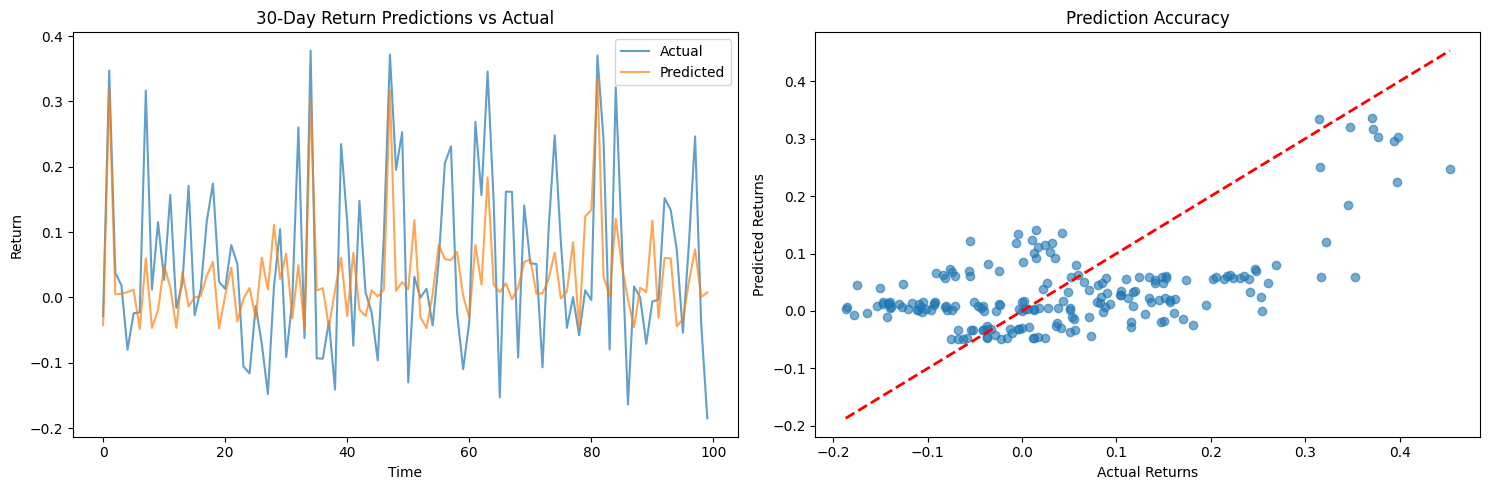

Using 50 features: ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change', 'returns_1d', 'returns_3d', 'returns_7d', 'log_returns', 'momentum_5', 'momentum_10', 'ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20', 'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'day_sin', 'day_cos', 'close_settlement', 'close_quote', 'volume_sma_20', 'day_of_week']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted 30-day return: 0.3675 (36.75%)


In [21]:
from feature_engineering import engineer_features
from data_loader import load_all_data
from sentiment import add_vader_sentiment, aggregate_daily_sentiment


btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
# Assuming you have your df with engineered features
df_news = add_vader_sentiment(df_news)
df_newsdaily_sentiment = aggregate_daily_sentiment(df_news)

# 3. Feature engineering
df = engineer_features(btc_ohlcv, daily_oi, daily_funding_rate, df_newsdaily_sentiment)

# Initialize predictor
predictor = BitcoinPredictor(sequence_length=60, prediction_horizon=30)

# Train model
history, X_val, y_val = predictor.train(df, epochs=100)

# Evaluate
metrics = predictor.evaluate_model(X_val, y_val)

# Plot results
predictor.plot_predictions(X_val, y_val)

# Predict next 30 days
next_30d_return = predictor.predict_next_30d(df)
print(f"Predicted 30-day return: {next_30d_return:.4f} ({next_30d_return*100:.2f}%)")


In [110]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model
from sklearn.model_selection import TimeSeriesSplit


class AdvancedBitcoinPredictor:
    def __init__(self, sequence_length=60, prediction_horizon=30, prune_gb=True, ridge_alpha=1.0):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
        self.models = {}
        self.meta_model = None
        self.dir_model = None
        self.scaler = None
        self.regime_scaler = None
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns',
                                 'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20',
                          'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal',
                          'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7',
                          'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
        
    def detect_market_regimes(self, df):
        """Detect market regimes using clustering on market conditions"""
        # Features for regime detection
        regime_features = [
            'volatility_20', 'rsi', 'bb_position', 'returns_7d', 
            'volume_avg_ratio', 'funding_rate', 'avg_vader_compound'
        ]
        
        available_regime_features = [f for f in regime_features if f in df.columns]
        
        if len(available_regime_features) < 4:
            print("Warning: Not enough regime features available, using simple volatility-based regimes")
            return self._simple_volatility_regimes(df)
        
        # Scale regime features
        self.regime_scaler = RobustScaler()
        regime_data = self.regime_scaler.fit_transform(df[available_regime_features].fillna(0))
        
        # Use K-means to identify market regimes
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(regime_data)
        
        # Assign regime labels based on characteristics
        regime_labels = []
        for i in range(4):
            regime_mask = regimes == i
            avg_vol = df.loc[regime_mask, 'volatility_20'].mean()
            avg_returns = df.loc[regime_mask, 'returns_7d'].mean()
            
            if avg_vol > df['volatility_20'].quantile(0.75):
                if avg_returns > 0:
                    label = 'bull_volatile'
                else:
                    label = 'bear_volatile'
            else:
                if avg_returns > 0:
                    label = 'bull_stable'
                else:
                    label = 'bear_stable'
            
            regime_labels.append(label)
        
        # Map regimes to labels
        regime_mapping = {i: regime_labels[i] for i in range(4)}
        labeled_regimes = [regime_mapping[r] for r in regimes]
        
        print(f"Detected regimes distribution:")
        unique, counts = np.unique(labeled_regimes, return_counts=True)
        for regime, count in zip(unique, counts):
            print(f"  {regime}: {count} days ({count/len(labeled_regimes)*100:.1f}%)")
        
        return labeled_regimes
    
    def _simple_volatility_regimes(self, df):
        """Simple volatility-based regime detection as fallback"""
        vol_25 = df['volatility_20'].quantile(0.25)
        vol_75 = df['volatility_20'].quantile(0.75)
        
        regimes = []
        for _, row in df.iterrows():
            vol = row['volatility_20']
            ret = row['returns_7d']
            
            if vol > vol_75:
                regime = 'bull_volatile' if ret > 0 else 'bear_volatile'
            else:
                regime = 'bull_stable' if ret > 0 else 'bear_stable'
            
            regimes.append(regime)
        
        return regimes
    
    def detect_extreme_conditions(self, df):
        """Detect extreme market conditions for special handling"""
        conditions = {}
        
        # Extreme volatility (top 10%)
        conditions['extreme_vol'] = df['volatility_20'] > df['volatility_20'].quantile(0.90)
        
        # Extreme returns (beyond 2 standard deviations)
        ret_std = df['returns_7d'].std()
        conditions['extreme_up'] = df['returns_7d'] > 2 * ret_std
        conditions['extreme_down'] = df['returns_7d'] < -2 * ret_std
        
        # Extreme funding rates
        if 'funding_rate' in df.columns:
            funding_std = df['funding_rate'].std()
            conditions['extreme_funding'] = np.abs(df['funding_rate']) > 2 * funding_std
        else:
            conditions['extreme_funding'] = pd.Series([False] * len(df))
        
        # Extreme sentiment
        if 'avg_vader_compound' in df.columns:
            sent_std = df['avg_vader_compound'].std()
            conditions['extreme_sentiment'] = np.abs(df['avg_vader_compound']) > 2 * sent_std
        else:
            conditions['extreme_sentiment'] = pd.Series([False] * len(df))
        
        # Combine all extreme conditions
        extreme_mask = (conditions['extreme_vol'] | conditions['extreme_up'] | 
                       conditions['extreme_down'] | conditions['extreme_funding'] | 
                       conditions['extreme_sentiment'])
        
        print(f"Extreme conditions detected in {extreme_mask.sum()} days ({extreme_mask.sum()/len(df)*100:.1f}%)")
        
        return extreme_mask, conditions
    
    def engineer_30day_target(self, df):
        """Engineer 30-day forward returns target with regime-aware adjustments"""
        df_target = df.copy()
        
        # Basic 30-day return
        df_target['target_return_30d'] = (df_target['close'].shift(-self.prediction_horizon) - 
                                         df_target['close']) / df_target['close']
        
        # Regime-adjusted targets (optional - can help with regime-specific training)
        df_target['target_return_raw'] = df_target['target_return_30d'].copy()
        
        # Detect regimes and extreme conditions
        regimes = self.detect_market_regimes(df_target)
        extreme_mask, _ = self.detect_extreme_conditions(df_target)
        
        df_target['market_regime'] = regimes
        df_target['extreme_condition'] = extreme_mask
        
        # Optional: Apply regime-specific target smoothing for extreme conditions
        for regime in ['bull_volatile', 'bear_volatile']:
            regime_mask = (df_target['market_regime'] == regime) & extreme_mask
            if regime_mask.sum() > 0:
                # Apply slight smoothing to extreme targets to prevent overfitting
                df_target.loc[regime_mask, 'target_return_30d'] = (
                    df_target.loc[regime_mask, 'target_return_30d'] * 0.8 + 
                    df_target.loc[regime_mask, 'target_return_30d'].rolling(5, center=True).mean() * 0.2
                )
        
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        df_target = df_target.dropna()
        
        return df_target
    
    def prepare_features(self, df):
        """Enhanced feature preparation with regime-aware scaling"""
        # Get all feature columns
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Add regime and extreme condition features
        if 'market_regime' in df.columns:
            # One-hot encode regimes
            regime_dummies = pd.get_dummies(df['market_regime'], prefix='regime')
            for col in regime_dummies.columns:
                df[col] = regime_dummies[col]
                available_features.append(col)
        
        if 'extreme_condition' in df.columns:
            available_features.append('extreme_condition')
        
        # Add additional engineered features for extreme conditions
        additional_features = [col for col in df.columns if col not in available_features 
                             and col not in ['target_return_30d', 'target_direction_30d', 
                                           'target_return_raw', 'market_regime', 'next_close', 
                                           'target_return', 'target_direction']]
        
        all_features = available_features + additional_features
        
        print(f"Using {len(all_features)} features for ensemble training")
        
        # Robust scaling with outlier handling
        self.scaler = RobustScaler(quantile_range=(5, 95))  # More aggressive outlier handling
        scaled_features = self.scaler.fit_transform(df[all_features].fillna(0))
        
        return scaled_features, all_features
    
    def build_cnn_lstm_model(self, input_shape, regime_specific=False):
        """Enhanced CNN-LSTM with attention and dropout for extreme conditions"""
        inputs = layers.Input(shape=input_shape)
        
        # Enhanced CNN branch with proper residual connections
        # First, project input to match CNN output dimensions
        input_projection = layers.Conv1D(filters=128, kernel_size=1, activation='linear', padding='same')(inputs)
        
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        
        # Now we can add residual connection (both are 128 filters)
        cnn_residual = layers.Add()([input_projection, cnn_branch])
        
        cnn_branch = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(cnn_residual)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = layers.Dropout(0.3)(cnn_branch)
        
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # Enhanced LSTM branch with bidirectional processing
        lstm_branch = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(inputs)
        lstm_branch = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(lstm_branch)
        lstm_branch = layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))(lstm_branch)
        
        # Multi-head attention mechanism
        attention = layers.Dense(64, activation='tanh')(lstm_branch)
        attention = layers.Dense(32, activation='tanh')(attention)
        attention = layers.Dense(1, activation='sigmoid')(attention)
        lstm_weighted = layers.multiply([lstm_branch, attention])
        
        # Combine features
        combined = layers.concatenate([cnn_branch, lstm_weighted])
        
        # Enhanced dense layers with adaptive dropout
        dense = layers.Dense(256, activation='relu')(combined)
        dense = layers.Dropout(0.4)(dense)
        dense = layers.Dense(128, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        
        # Output layer
        output = layers.Dense(1, activation='linear', name='return_prediction')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        
        # Compile with Huber loss (more robust to outliers)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.Huber(delta=0.1),  # Robust to outliers
            metrics=['mae', 'mse']
        )
        
        return model
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences with regime information"""
        X, y, regime_seq = [], [], []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            X.append(features[i:(i + self.sequence_length)])
            y.append(targets[i + self.sequence_length])
            if regimes is not None:
                regime_seq.append(regimes[i + self.sequence_length])
        
        return np.array(X), np.array(y), regime_seq
    
    def train_ensemble(self, df, validation_split=0.2, epochs=150, batch_size=32):
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values

        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, shuffle=False)
        X_train_flat = X_train.reshape(len(X_train), -1)
        X_val_flat = X_val.reshape(len(X_val), -1)

        # Base models
        self.models['cnn_lstm'] = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        self.models['cnn_lstm'].fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks=[es, rl], verbose=1)

        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        self.models['random_forest'].fit(X_train_flat, y_train)

        if not self.prune_gb:
            self.models['gradient_boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
            self.models['gradient_boosting'].fit(X_train_flat, y_train)

        # Stacking
        preds = []
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if not self.prune_gb else [])
        for name in names:
            if name == 'cnn_lstm':
                preds.append(self.models[name].predict(X_val).flatten())
            else:
                preds.append(self.models[name].predict(X_val_flat))
        stacked = np.vstack(preds).T  # shape (n_samples, n_models)

        # Ridge meta-learner with non-negative coefficients
        self.meta_model = Ridge(alpha=self.ridge_alpha, positive=True)
        self.meta_model.fit(stacked, y_val)
        print("Meta-learner coefs:", self.meta_model.coef_)
        return X_val, y_val, regime_seq

    def predict_ensemble(self, X):
        """Make ensemble predictions and also return individual model outputs and meta weights."""
        # Compute individual predictions
        individual_preds = {}
        X_flat = X.reshape(len(X), -1)
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if 'gradient_boosting' in self.models else [])
        for name in names:
            if name == 'cnn_lstm':
                pred = self.models[name].predict(X).flatten()
            else:
                pred = self.models[name].predict(X_flat)
            individual_preds[name] = pred

        # Stack for meta-model
        stacked = np.vstack([individual_preds[name] for name in names]).T
        ensemble = self.meta_model.predict(stacked)

        # Meta-model weights for interpretability
        weights = {'meta_coefs': self.meta_model.coef_}
        return ensemble.reshape(-1,1), individual_preds, weights

    def evaluate_ensemble(self, X_val, y_val, regime_seq_val=None):
        """Evaluate ensemble performance with provided validation set."""
        ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)

        # Calculate metrics
        mae = mean_absolute_error(y_val, ensemble_pred)
        mse = mean_squared_error(y_val, ensemble_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, ensemble_pred)
        direction_accuracy = np.mean(np.sign(y_val) == np.sign(ensemble_pred.flatten()))

        print(f"\n=== Ensemble Performance ===")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy: {direction_accuracy:.4f}")

        print(f"\n=== Individual Model Performance ===")
        for model_name, pred in individual_preds.items():
            model_mae = mean_absolute_error(y_val, pred)
            model_mse = mean_squared_error(y_val, pred)
            model_rmse = np.sqrt(mse)
            model_r2 = r2_score(y_val, pred)
            model_dir_acc = np.mean(np.sign(y_val) == np.sign(pred.flatten()))
            print(f"{model_name}: MAE={model_mae:.6f}, MSE={model_mse:.6f}, RMSE={model_rmse:.6f}, R²={model_r2:.6f}, Dir_Acc={model_dir_acc:.4f}")

        print(f"\nMeta-model weights: {weights['meta_coefs']}")
        return {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'direction_accuracy': direction_accuracy,
            'individual_performance': individual_preds,
            'meta_weights': weights['meta_coefs']
        }

    def validate_meta_learner(self, df, n_splits=5, stratify=False, epochs=150, batch_size=32):
        """
        Perform rolling-window cross-validation to assess stability of meta-learner coefficients.
        Prints per-fold and mean coefficients for stacking meta-model.
        """
        # Prepare processed data
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        X, y, regime_seq = self.create_sequences(features, targets, regimes)

        # Select splitter
        if stratify:
            splitter = StratifiedKFold(n_splits=n_splits, shuffle=False)
            split_fn = lambda: splitter.split(X, regime_seq)
        else:
            splitter = TimeSeriesSplit(n_splits=n_splits)
            split_fn = lambda: splitter.split(X)

        coefs = []
        for fold, (train_idx, val_idx) in enumerate(split_fn()):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            X_train_flat = X_train.reshape(len(X_train), -1)
            X_val_flat = X_val.reshape(len(X_val), -1)

            # Retrain base models
            m1 = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
            m1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                   batch_size=batch_size, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)], verbose=0)
            m2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            m2.fit(X_train_flat, y_train)
            models = [m1, m2]
            if not self.prune_gb:
                m3 = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
                m3.fit(X_train_flat, y_train)
                models.append(m3)

            # Stack predictions
            preds = []
            for i, mdl in enumerate(models):
                if i == 0:
                    preds.append(mdl.predict(X_val).flatten())
                else:
                    preds.append(mdl.predict(X_val_flat))
            stacked = np.vstack(preds).T

            # Fit Ridge meta-model
            meta = Ridge(alpha=self.ridge_alpha, positive=True)
            meta.fit(stacked, y_val)
            print(f"Fold {fold+1} coefs: {meta.coef_}")
            coefs.append(meta.coef_)

        coefs = np.array(coefs)
        print("Mean coefs:", coefs.mean(axis=0), "Std dev:", coefs.std(axis=0))
        return coefs
            
    def build_direction_model(self, input_shape):
        """Build a Bidirectional LSTM for binary direction classification."""
        inp = layers.Input(shape=input_shape)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(inp)
        x = layers.Bidirectional(layers.LSTM(32, dropout=0.2))(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(1, activation='sigmoid', name='direction')(x)
        model = Model(inputs=inp, outputs=out)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train_direction_classifier(self, df, validation_split=0.2, epochs=50, batch_size=32):
        """Train the direction classifier using 30-day direction labels."""
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_direction_30d'].values
        X, y, _ = self.create_sequences(features, targets)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, shuffle=False)

        self.dir_model = self.build_direction_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        history = self.dir_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es, rl],
            verbose=1
        )
        return history, X_val, y_val

    def predict_direction(self, X):
        """Predict direction probabilities (0–1) with the trained classifier."""
        if self.dir_model is None:
            raise ValueError("Direction model not trained. Call train_direction_classifier first.")
        return self.dir_model.predict(X, verbose=0).flatten()

    def predict_next_30d(self, df, threshold=0.5):
        """Predict next 30-day direction & return, gating regression by classifier."""
        # Prepare regression inputs
        features, _ = self.prepare_features(df)
        seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)

        # Get direction probability
        dir_prob = self.predict_direction(seq)

        # Get regression prediction
        reg_pred, _, _ = self.predict_ensemble(seq)
        ret_pred = reg_pred[0][0]

        # Gate output based on direction confidence
        direction = 1 if dir_prob >= threshold else 0
        gated_return = ret_pred if direction == 1 else -ret_pred

        return {'direction_prob': dir_prob[0],
                'predicted_direction': direction,
                'predicted_return': gated_return}
    
    def evaluate_direction_classifier(self, X_val, y_val):
        """
        Evaluate the trained direction classifier on validation data.
        Computes accuracy, precision, recall, F1-score, and returns a report.
        """
        if self.dir_model is None:
            raise ValueError("Direction model not trained. Call train_direction_classifier first.")
        # Predict probabilities and labels
        probs = self.dir_model.predict(X_val, verbose=0).flatten()
        preds = (probs >= 0.5).astype(int)

        # Compute metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
        acc = accuracy_score(y_val, preds)
        prec = precision_score(y_val, preds)
        rec = recall_score(y_val, preds)
        f1 = f1_score(y_val, preds)
        auc = roc_auc_score(y_val, probs)
        cm = confusion_matrix(y_val, preds)

        # Print report
        print("=== Direction Classifier Evaluation ===")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'roc_auc': auc,
            'confusion_matrix': cm
        }

    


In [111]:
btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
# Assuming you have your df with engineered features
df_news = add_vader_sentiment(df_news)
df_newsdaily_sentiment = aggregate_daily_sentiment(df_news)

# 3. Feature engineering
df = engineer_features(btc_ohlcv, daily_oi, daily_funding_rate, df_newsdaily_sentiment)

# Initialize predictor
predictor = AdvancedBitcoinPredictor(sequence_length=60, prediction_horizon=30)


In [112]:
# Train ensemble
X_val, y_val, regime_seq = predictor.train_ensemble(df, epochs=150)

# Evaluate ensemble
metrics = predictor.evaluate_ensemble(X_val, y_val, regime_seq)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0652 - mae: 0.7004 - mse: 1.1407 - val_loss: 0.0080 - val_mae: 0.1214 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0265 - mae: 0.3116 - mse: 0.1967 - val_loss: 0.0069 - val_mae: 0.1089 - val_mse: 0.0206 - learning_rate: 5.0000e-04
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0200 - mae: 0.2458 - mse: 0.1172 - val_loss: 0.0071 - val_mae: 0.1107 - val_mse: 0.0215 - learning_rate: 5.0000e-04
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0157 - mae: 0.2011 - mse: 0.0751 - val_loss: 0.0070 - val_mae: 0.1093 - val_mse: 0.0203 - learning_rate: 5.0000e-04
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0142 - mae: 0.1847 - mse: 0.0648 - val_lo

In [113]:
history, X_val, y_val = predictor.train_direction_classifier(df)
metrics = predictor.evaluate_direction_classifier(X_val, y_val)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5775 - loss: 0.6755 - val_accuracy: 0.6131 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7422 - loss: 0.6120 - val_accuracy: 0.6281 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7516 - loss: 0.5265 - val_accuracy: 0.5980 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8187 - loss: 0.4369 - val_accuracy: 0.6332 - val_loss: 0.8569 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8361 - loss: 0.3537 - val_accuracy: 0.6281 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy:

In [79]:
coef = predictor.validate_meta_learner(df)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Fold 1 coefs: [0.17366901 0.        ]
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Fold 2 coefs: [0.         0.37226105]


KeyboardInterrupt: 

In [108]:
def backtest_hybrid(predictor, df, threshold=0.7):
    """
    Hybrid backtest: use direction classifier as gate on regression forecasts.
    Returns a DataFrame and performance metrics.
    """
    # 1. Prepare data
    df_p = predictor.engineer_30day_target(df)
    features, _ = predictor.prepare_features(df_p)
    X_seq, _, _ = predictor.create_sequences(
        features,
        df_p['target_direction_30d'].values
    )

    # 2. Get model outputs
    probs = predictor.predict_direction(X_seq)              # shape (n,)
    reg_preds_2d, _, _ = predictor.predict_ensemble(X_seq)   # shape (n,1)
    reg_preds = reg_preds_2d.flatten()                      # now shape (n,)

    # 3. Build strategy returns (long/short/flat)
    strat_return = np.where(
        probs >= threshold,
        reg_preds,
        np.where(probs <= (1 - threshold),
                 -reg_preds,
                 0.0)
    )

    # 4. Assemble results (all 1-D arrays)
    results = pd.DataFrame({
        'direction_prob': probs,
        'predicted_return': reg_preds,
        'strategy_return': strat_return
    })

    # 5. Cumulative P&L
    results['cum_strategy'] = (1 + results['strategy_return']).cumprod() - 1

    # 6. Metrics
    sharpe = (
        results['strategy_return'].mean() /
        results['strategy_return'].std()
    ) * np.sqrt(252)
    total = results['cum_strategy'].iloc[-1]
    drawdown = (
        results['cum_strategy'].cummax() -
        results['cum_strategy']
    ).max()

    perf = {
        'sharpe_ratio': sharpe,
        'max_drawdown': drawdown,
        'total_return': total
    }
    return results, perf


In [109]:
predictor.train_direction_classifier(df)
predictor.train_ensemble(df)
results_df, perf_metrics = backtest_hybrid(predictor, df, threshold=0.7)
print(perf_metrics)

Detected regimes distribution:
  bear_stable: 800 days (71.9%)
  bull_stable: 312 days (28.1%)
Extreme conditions detected in 260 days (23.4%)
Using 53 features for ensemble training
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5472 - loss: 0.6814 - val_accuracy: 0.5226 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6467 - loss: 0.6409 - val_accuracy: 0.5829 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7286 - loss: 0.5579 - val_accuracy: 0.5678 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8197 - loss: 0.4329 - val_accuracy: 0.6231 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8721 - loss: 0.3546 - val_accuracy: 0.6482 - val_loss: 0.8068 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: